### data preprocessing method for few-shot method
#### HE CLAHE
#### Top Hat
#### Adaptive Gamma Correction
#### retinex
#### space-variant luminance map
#### zero-dce

### top_hat
### 对原图x先腐蚀，再膨胀，得到图片I(x)
### top_hat(x)=x-I(x)
#### 腐蚀操作
##### 类似于中值平滑，有一个核，取核中像素值的最小值代替锚点位置的像素值，使图像中较暗的区域面积增大，较亮的的区域面积减小。如果是一张黑底，白色前景的二值图，就会使白色的前景物体颜色变小，就像被腐蚀了一样。
#### 膨胀操作
##### 和腐蚀操作相反，取核中像素值的最大值代替锚点位置的像素值，使图像中较亮的区域增大，较暗的区域减小。如果是一张黑底，白色前景的二值图，就会使白色的前景物体颜色面积变大，就像膨胀了一样
#### 先进行腐蚀操作，后进行膨胀操作，主要用来去除一些较亮的部分，即先腐蚀掉不要的部分，再进行膨胀; 先进行膨胀操作，后进行腐蚀操作，主要用来去除一些较暗的部分。



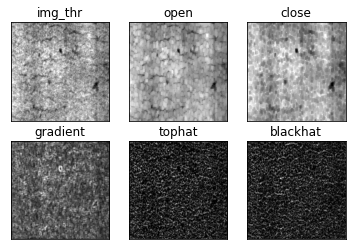

In [5]:
import cv2 as cv
import matplotlib.pyplot as plt

img = cv.imread(r"/home/dlsuncheng/FSOD/FsMMdet/Datasets/NEU_DET/JPEGImages/crazing_6.jpg")
img_thr = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,5))
open = cv.morphologyEx(img_thr,cv.MORPH_OPEN,kernel,iterations=1)
close = cv.morphologyEx(img_thr,cv.MORPH_CLOSE,kernel,iterations=1)
gradient = cv.morphologyEx(img_thr,cv.MORPH_GRADIENT,kernel,iterations=1)
tophat = cv.morphologyEx(img_thr,cv.MORPH_TOPHAT,kernel,iterations=1)
blackhat = cv.morphologyEx(img_thr,cv.MORPH_BLACKHAT,kernel,iterations=1)

images=[img_thr,open,close,gradient,tophat,blackhat]
titles=["img_thr","open","close","gradient","tophat","blackhat"]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],"gray")
    plt.title(titles[i])
    plt.xticks([]),    plt.yticks([])
plt.show()

### HE CLAHE

In [2]:
import cv2
import numpy as np
import math
import argparse
import os
from tqdm import tqdm
import time


class GaussianBlurConv():
    '''
    高斯滤波
    依据图像金字塔和高斯可分离滤波器思路加速
    '''
    def FilterGaussian(self, img, sigma):
        '''
        高斯分离卷积，按照x轴y轴拆分运算，再合并，加速运算
        '''
        # reject unreasonable demands
        if sigma > 300:
            sigma = 300
        # 获取滤波器尺寸且强制为奇数
        kernel_size = round(sigma * 3 * 2 +1) | 1   # 当图像类型为CV_8U的时候能量集中区域为3 * sigma,
        # 创建内核
        kernel = cv2.getGaussianKernel(ksize=kernel_size, sigma=sigma, ktype=cv2.CV_32F)
        # 初始化图像
        temp = np.zeros_like(img)
        # x轴滤波
        for j in range(temp.shape[0]):
            for i in range(temp.shape[1]):
                # 内层循环展开
                v1 = v2 = v3 = 0
                for k in range(kernel_size):
                    source = math.floor(i+ kernel_size/2 -k)        # 把第i个坐标和kernel的中心对齐 -k是从右往左遍历kernel对应的图像，得到与kernel的第k个元素相乘的图像坐标
                    if source < 0:
                        source = source * -1            # 如果图像超出左边缘，就反向，对称填充
                    if source > img.shape[1]:
                        source = math.floor(2 * (img.shape[1] - 1) - source)   # 图像如果超出右边缘，就用左边从头数着补
                    v1 += kernel[k] * img[j, source, 0]
                    if temp.shape[2] == 1: continue
                    v2 += kernel[k] * img[j, source, 1]
                    v3 += kernel[k] * img[j, source, 2]
                temp[j, i, 0] = v1
                if temp.shape[2] == 1: continue
                temp[j, i, 1] = v2
                temp[j, i, 2] = v3
        # 分离滤波，先在原图用x轴的滤波器滤波，得到temp图，再用y轴滤波在temp图上滤波，结果一致
        # y轴滤波
        for i in range(img.shape[1]):         # height
            for j in range(img.shape[0]):
                v1 = v2 = v3 = 0
                for k in range(kernel_size):
                    source = math.floor(j + kernel_size/2 - k)
                    if source < 0:
                        source = source * -1
                    if source > temp.shape[0]:
                        source = math.floor(2 * (img.shape[0] - 1) - source)   # 上下对称
                    v1 += kernel[k] * temp[source, i, 0]
                    if temp.shape[2] == 1: continue
                    v2 += kernel[k] * temp[source, i, 1]
                    v3 += kernel[k] * temp[source, i, 2]
                img[j, i, 0] = v1
                if img.shape[2] == 1: continue
                img[j, i, 1] = v2
                img[j, i, 2] = v3
        return img

    def FastFilter(self, img, sigma):
        '''
        快速滤波，按照图像金字塔，逐级降低图像分辨率，对应降低高斯核的sigma，
        当sigma转换成高斯核size小于10，再进行滤波，后逐级resize
        递归思路
        '''
        # reject unreasonable demands
        if sigma > 300:
            sigma = 300
        # 获取滤波尺寸，且强制为奇数
        kernel_size = round(sigma * 3 * 2 + 1) | 1  # 当图像类型为CV_8U的时候能量集中区域为3 * sigma,
        # 如果s*sigma小于一个像素，则直接退出
        if kernel_size < 3:
            return
        # 处理方式(1) 滤波  (2) 高斯光滑处理  (3) 递归处理滤波器大小
        if kernel_size < 10:
            # img = self.FilterGaussian(img, sigma)
            img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)   # 官方函数
            return img
        else:
            # 若降采样到最小，直接退出
            if img.shape[1] <= 2 or img.shape[0] <= 2:
                return img
            sub_img = np.zeros_like(img)        # 初始化降采样图像
            sub_img = cv2.pyrDown(img, sub_img)           # 使用gaussian滤波对输入图像向下采样，缩放二分之一，仅支持CV_GAUSSIAN_5x5
            sub_img = self.FastFilter(sub_img, sigma/2.0)
            print(sub_img.shape)
            print(img.shape)
            img = cv2.resize(sub_img, (img.shape[1], img.shape[0]))              # resize到原图大小
            return img

    def __call__(self, x, sigma):
        x = self.FastFilter(img, sigma)
        return x


class Retinex(object):
    """
    SSR: baseline
    MSR: keep the high fidelity and the dynamic range as well as compressing img
    MSRCR_GIMP:
      Adapt the dynamics of the colors according to the statistics of the first and second order.
      The use of the variance makes it possible to control the degree of saturation of the colors.
    """
    def __init__(self, model='MSR', sigma=[30, 150, 300], restore_factor=2.0, color_gain=10.0, gain=270.0, offset=128.0):
        self.model_list = ['SSR','MSR']
        if model in self.model_list:
            self.model = model
        else:
            raise ValueError
        self.sigma = sigma        # 高斯核的方差
        # 颜色恢复
        self.restore_factor = restore_factor     # 控制颜色修复的非线性
        self.color_gain = color_gain             # 控制颜色修复增益
        # 图像恢复
        self.gain = gain           # 图像像素值改变范围的增益
        self.offset = offset       # 图像像素值改变范围的偏移量

    def _SSR(self, img, sigma):
        kernel_size = round(sigma * 3 * 2 +1) | 1   # 当图像类型为CV_8U的时候能量集中区域为3 * sigma,
        filter_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
        retinex = np.log10(img) - np.log10(filter_img)
        return retinex

    def _MSR(self, img, simga):
        retinex = np.zeros_like(img)
        for sig in simga:
            retinex += self._SSR(img, sig)
        retinex = retinex / float(len(self.sigma))
        return retinex

    def _colorRestoration(self, img, retinex):
        img_sum = np.sum(img, axis=2, keepdims=True)  # 在通道层面求和
        # 颜色恢复
        # 权重矩阵归一化 并求对数，得到颜色增益
        color_restoration = np.log10((img * self.restore_factor / img_sum) * 1.0 + 1.0)
        # 将Retinex做差后的图像，按照权重和颜色增益重新组合
        img_merge = retinex * color_restoration * self.color_gain
        # 恢复图像
        img_restore = img_merge * self.gain + self.offset
        return img_restore

    def _simplestColorBalance(self, img, low_clip, high_clip):
        total = img.shape[0] * img.shape[1]
        for i in range(img.shape[2]):
            unique, counts = np.unique(img[:, :, i], return_counts=True)  # 返回新列表元素在旧列表中的位置，并以列表形式储存在s中
            current = 0
            for u, c in zip(unique, counts):
                if float(current) / total < low_clip:
                    low_val = u
                if float(current) / total < high_clip:
                    high_val = u
                current += c

            img[:, :, i] = np.maximum(np.minimum(img[:, :, i], high_val), low_val)

        return img

    def _MSRCR_GIMP(self, img):

        # self.img = results['img']
        self.img = np.float32(img) + 1.0
        if self.model == 'SSR':
            self.retinex = self._SSR(self.img, self.sigma)
        elif self.model == 'MSR':
            self.retinex = self._MSR(self.img, self.sigma)
        # 颜色恢复 图像恢复
        self.img_restore = self._colorRestoration(self.img, self.retinex)

        return self.img_restore

    def __call__(self, img):
        return self._MSRCR_GIMP(img)

    def __repr__(self):
        repr_str = self.__class__.__name__
        repr_str += '{},sigma={},dynamic={}'.format(self.model, self.sigma, self.Dynamic)
        return repr_str

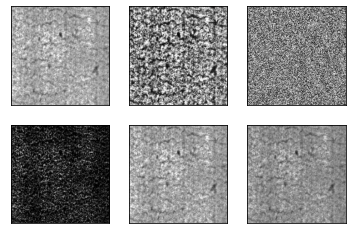

In [3]:
from albumentations import Equalize,CLAHE,RandomGamma,RandomContrast
import matplotlib.pyplot as plt
import cv2 as cv
# from mmdet.datasets.pipelines.transforms import Retinex
img = cv.imread(r"/home/dlsuncheng/FSOD/FsMMdet/Datasets/NEU_DET/Zero-DCE-NEU-DET/crazing_6.jpg")
# img = cv.imread(r"/home/dlsuncheng/FSOD/FsMMdet/Datasets/NEU_DET/JPEGImages/crazing_20.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img_thr = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,5))
tophat = cv.morphologyEx(img_thr,cv.MORPH_TOPHAT,kernel,iterations=1)


clahe = CLAHE(clip_limit=(1, 4), tile_grid_size=(8, 8), always_apply=False, p=1)
randomgamma = RandomGamma((80,120),eps=None,always_apply=False,p=1)
RC = RandomContrast((-0.4,0.4),False,1)

retinex = Retinex(model='MSR', sigma=[30,150,300],
       restore_factor=2.0, color_gain=6.0, gain=128.0, offset=128.0)

img_CLAHE = clahe(image=img)['image']

img_RG = randomgamma(image=img)['image']

img_RC = RC(image=img)['image']
img_retinex = retinex(img)

img_retinex_rs = (img_retinex * 255).astype(np.uint8)

images=[img,img_CLAHE,img_retinex_rs,tophat,img_RG,img_RC]
# titles=["Raw","CLAHE","Retinex","Tophat","Gamma","Random-Contrast"]
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i],"gray")
    # plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
# plt.show()

# plt.savefig("augment_list_zero_dce.png", dpi=200)#指定分辨率



# plt.subplot(1, 5, 1)
# plt.imshow(img)
# plt.subplot(1, 5, 2)
# plt.imshow(img_CLAHE)
# plt.subplot(1, 5, 3)
# plt.imshow(img_RG)
# plt.subplot(1, 5, 4)
# plt.imshow(img_RG)
# plt.subplot(1, 5, 5)
# plt.imshow((img_retinex * 255).astype(np.uint8))
# plt.show()


# he = Equalize (mode='cv', by_channels=True, mask=None, mask_params=(), always_apply=False, p=1) #均衡图像直方图

# clahe = CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=1) #将 对比度受限的自适应直方图均衡 应用于输入图像。提升对比度

# img_he = he(img)
# img_clahe = clahe(img)
# images=[img,img_he,img_clahe]
# titles=["raw_img","img_he","img_clahe"]
# for i in range(3):
#     plt.subplot(1,3,i+1),plt.imshow(images[i],"gray")
#     plt.title(titles[i])
#     plt.xticks([]),    plt.yticks([])
# plt.show()

### gamma correction

In [ ]:
import cv2
import numpy as np
 
 
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma
 
    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
 
    return cv2.LUT(src, table)
 
 
img = cv2.imread('test.jpg')
gammaImg = gammaCorrection(img, 2.2)
 
cv2.imshow('Original image', img)
cv2.imshow('Gamma corrected image', gammaImg)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:

%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import fractional_matrix_power

def image_agcwd(img, a=0.25):
    h,w = img.shape[:2]
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf.max()
    prob_normalized = hist / hist.sum()

    unique_intensity = np.unique(img)
    intensity_max = unique_intensity.max()
    intensity_min = unique_intensity.min()
    prob_min = prob_normalized.min()
    prob_max = prob_normalized.max()
    
    pn_temp = (prob_normalized - prob_min) / (prob_max - prob_min)
    pn_temp[pn_temp>0] = prob_max * (pn_temp[pn_temp>0]**a)
    pn_temp[pn_temp<0] = prob_max * (-((-pn_temp[pn_temp<0])**a))
    prob_normalized_wd = pn_temp / pn_temp.sum() # normalize to [0,1]
    cdf_prob_normalized_wd = prob_normalized_wd.cumsum()
    inverse_cdf = 1 - cdf_prob_normalized_wd
    
    img_new = img.copy()
    for i in unique_intensity:
        img_new[img==i] = np.round(255 * (i / 255)**inverse_cdf[i])
   
#     print ("%f %f"%(prob_min, prob_max))
    plt.plot(inverse_cdf, color = 'b')
#     plt.plot(inverse_cdf, color = 'r')
#     plt.ylim([0,0.15])
    plt.show()
    
    return img_new

def image_agcwd_truncated(img, a=0.75):
    h,w = img.shape[:2]
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf.max()
    prob_normalized = hist / hist.sum()

    unique_intensity = np.unique(img)
    intensity_max = unique_intensity.max()
    intensity_min = unique_intensity.min()
    prob_min = prob_normalized.min()
    prob_max = prob_normalized.max()
    
    pn_temp = (prob_normalized - prob_min) / (prob_max - prob_min)
    pn_temp[pn_temp>0] = prob_max * (pn_temp[pn_temp>0]**a)
    pn_temp[pn_temp<0] = prob_max * (-((-pn_temp[pn_temp<0])**a))
    prob_normalized_wd = pn_temp / pn_temp.sum() # normalize to [0,1]
    cdf_prob_normalized_wd = prob_normalized_wd.cumsum()
    inverse_cdf = np.maximum(0.5,1 - cdf_prob_normalized_wd)
    
    img_new = img.copy()
    for i in unique_intensity:
        img_new[img==i] = np.round(255 * (i / 255)**inverse_cdf[i])
   
#     print ("%f %f"%(prob_min, prob_max))
#     print (cdf_prob_normalized_wd.min(),cdf_prob_normalized_wd.max())
#     print(hist.sum(),h*w)
    plt.plot(prob_normalized_wd, color = 'b')
#     plt.plot(inverse_cdf, color = 'r')
    plt.ylim([0,0.2])
    plt.show()
    
    return img_new


def process_bright(img):
    img_negative = 255 - img
#     plt.imshow(img_negative, cmap='gray')
#     plt.title('Negative Image')
#     plt.show()
    
    agcwd = image_agcwd(img_negative)
    reversed = 255 - agcwd
    return reversed

def process_dimmed(img):
    agcwd = image_agcwd_truncated(img)
    return agcwd

# Read image
img = cv2.imread('outputs/figure1.jpg',)
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y = YCrCb[:,:,0]
plt.imshow(rgb)
plt.title('RGB')
plt.show()
# plt.imshow(Y, cmap='gray')
# plt.title('Gray Scale')
# plt.show()

# Determine whether image is bright or dimmed
threshold = 0.3
T_t = 112 # Global average brightness 
M,N = img.shape[:2]
m_I = np.sum(Y/(M*N)) 
t = (m_I - T_t)/ T_t

img_output = None
if t < -threshold:
    print ("Dimmed Image")
    result = process_dimmed(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2RGB)
    plt.imshow(img_output)
    plt.title('Output')
    plt.show()
elif t > threshold:
    print ("Bright Image")
    result = process_bright(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2RGB)
    plt.imshow(img_output)
    plt.title('Output')
    plt.show()

In [ ]:
import cv2
import glob
import argparse
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import fractional_matrix_power

def image_agcwd(img, a=0.25, truncated_cdf=False):
    h,w = img.shape[:2]
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf.max()
    prob_normalized = hist / hist.sum()

    unique_intensity = np.unique(img)
    intensity_max = unique_intensity.max()
    intensity_min = unique_intensity.min()
    prob_min = prob_normalized.min()
    prob_max = prob_normalized.max()
    
    pn_temp = (prob_normalized - prob_min) / (prob_max - prob_min)
    pn_temp[pn_temp>0] = prob_max * (pn_temp[pn_temp>0]**a)
    pn_temp[pn_temp<0] = prob_max * (-((-pn_temp[pn_temp<0])**a))
    prob_normalized_wd = pn_temp / pn_temp.sum() # normalize to [0,1]
    cdf_prob_normalized_wd = prob_normalized_wd.cumsum()
    
    if truncated_cdf: 
        inverse_cdf = np.maximum(0.5,1 - cdf_prob_normalized_wd)
    else:
        inverse_cdf = 1 - cdf_prob_normalized_wd
    
    img_new = img.copy()
    for i in unique_intensity:
        img_new[img==i] = np.round(255 * (i / 255)**inverse_cdf[i])
   
    return img_new

def process_bright(img):
    img_negative = 255 - img
    agcwd = image_agcwd(img_negative, a=0.25, truncated_cdf=False)
    reversed = 255 - agcwd
    return reversed

def process_dimmed(img):
    agcwd = image_agcwd(img, a=0.75, truncated_cdf=True)
    return agcwd

def main():
    parser = argparse.ArgumentParser(description='IAGCWD')
    parser.add_argument('--input', dest='input_dir', default='./input/', type=str, \
                        help='Input directory for image(s)')
    parser.add_argument('--output', dest='output_dir', default='./output/', type=str, \
                        help='Output directory for image(s)')
    args = parser.parse_args()
    
    img_paths = glob.glob(args.input_dir+'*')
    for path in img_paths:
        img = cv2.imread(path, 1)
        name = path.split('\\')[-1].split('.')[0]
        
        # Extract intensity component of the image
        YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        Y = YCrCb[:,:,0]
        # Determine whether image is bright or dimmed
        threshold = 0.3
        exp_in = 112 # Expected global average intensity 
        M,N = img.shape[:2]
        mean_in = np.sum(Y/(M*N)) 
        t = (mean_in - exp_in)/ exp_in
        
        # Process image for gamma correction
        img_output = None
        if t < -threshold: # Dimmed Image
            print (name + ": Dimmed")
            result = process_dimmed(Y)
            YCrCb[:,:,0] = result
            img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
        elif t > threshold:
            print (name + ": Bright Image") # Bright Image
            result = process_bright(Y)
            YCrCb[:,:,0] = result
            img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
        else:
            img_output = img

        cv2.imwrite(args.output_dir+name+'.jpg', img_output)

if __name__ == '__main__':
    main()

In [40]:
from PIL import Image, ExifTags
file = "/home/dlsuncheng/FSOD/FsMMdet/Datasets/NEU_DET/JPEGImages/crazing_20.jpg"
img = cv.imread(file)
img_cv = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_pil = Image.open(file)
# im.save(fp, format=format)
# try:
#     for orientation in ExifTags.TAGS.keys() : 
#         if ExifTags.TAGS[orientation]=='Orientation' : break 
#     exif=dict(img._getexif().items())
#     print(exif[orientation])
#     # if   exif[orientation] == 3 : 
#     #     img=img.rotate(180, expand = True)
#     # elif exif[orientation] == 6 : 
#     #     img=img.rotate(270, expand = True)
#     # elif exif[orientation] == 8 : 
#     #     img=img.rotate(90, expand = True)
# except:
#     pass
